# Named Entity Recognition

In this notebook, we will explore how to implement a Named Entity Recognition Model using BERT and Pytorch.

* Data for fine-tuning the NER comes from the [Groningen Meaning Bank (GMB)](https://gmb.let.rug.nl/) available on Kaggle as [Annotated Corpus for Named Entity Recognition](https://www.kaggle.com/datasets/abhinavwalia95/entity-annotated-corpus)
* HuggingFace already provides a [BertForTokenClassification](https://huggingface.co/docs/transformers/main/en/model_doc/bert#transformers.BertForTokenClassification) that is suitable for NER so we will use that for our model.


## Environment Setup

In [ ]:
!pip install transformers datasets seqeval

     |████████████████████████████████| 3.8 MB 5.5 MB/s 
     |████████████████████████████████| 325 kB 57.6 MB/s 
     |████████████████████████████████| 43 kB 2.4 MB/s 
     |████████████████████████████████| 596 kB 45.4 MB/s 
     |████████████████████████████████| 6.5 MB 36.4 MB/s 
     |████████████████████████████████| 67 kB 5.9 MB/s 
     |████████████████████████████████| 895 kB 43.5 MB/s 
     |████████████████████████████████| 136 kB 48.2 MB/s 
     |████████████████████████████████| 1.1 MB 42.3 MB/s 
     |████████████████████████████████| 212 kB 59.2 MB/s 
     |████████████████████████████████| 127 kB 42.3 MB/s 
     |████████████████████████████████| 144 kB 50.2 MB/s 
     |████████████████████████████████| 94 kB 4.2 MB/s 
     |████████████████████████████████| 271 kB 52.9 MB/s 
  Created wheel for seqeval: filename=seqeval-1.2.2-py3-none-any.whl size=16180 sha256=c7cba8bfe6ff229d782b8bb6b13d0b8c5ff1ca6cc2f424b6b3891d1794afdfab
  Stored in directory: /root/.cache/pip/whe

## Imports

In [ ]:
import csv
import json
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import random
import shutil
import torch

from collections import Counter, defaultdict
from datasets import load_dataset, ClassLabel
from seqeval.metrics import classification_report, f1_score
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix
from torch.nn.functional import cross_entropy
from torch.optim import AdamW
from torch.utils.data import DataLoader
from transformers import (
    AutoTokenizer, AutoModelForTokenClassification, AutoConfig,
    DataCollatorForTokenClassification,
    get_scheduler
)

## Data Processing

I downloaded the GMB dataset from Kaggle (it's the `ner_dataset.csv` file) and uploaded it into my Google Drive. Other approaches could be to get it direct from google storage. (TODO)

In [ ]:
from google.colab import drive

drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!ls /content/drive/MyDrive/odsc-2022-data/GMB/

bert-base-cased-gmb-ner        ner.csv
distilbert-base-cased-gmb-ner  ner_dataset.csv


In [ ]:
!head /content/drive/MyDrive/odsc-2022-data/GMB/ner_dataset.csv

Sentence #,Word,POS,Tag
Sentence: 1,Thousands,NNS,O
,of,IN,O
,demonstrators,NNS,O
,have,VBP,O
,marched,VBN,O
,through,IN,O
,London,NNP,B-geo
,to,TO,O
,protest,VB,O


In [ ]:
GS_DATA_DIR = "/content/drive/MyDrive/odsc-2022-data/GMB/"
DATA_DIR = "data"

NER_FILEPATH = os.path.join(GS_DATA_DIR, "ner_dataset.csv")

OUTPUT_FILEPATHS = [
  os.path.join(DATA_DIR, "gmb-train.jsonl"),
  os.path.join(DATA_DIR, "gmb-valid.jsonl"),
  os.path.join(DATA_DIR, "gmb-test.jsonl")
]

# BASE_MODEL_NAME = "bert-base-cased"
BASE_MODEL_NAME = "distilbert-base-cased"
MODEL_DIR = os.path.join(DATA_DIR, "{:s}-gmb-ner".format(BASE_MODEL_NAME))

In [ ]:
def write_output(tokens, labels, output_files, num_writter):
  assert(len(tokens) == len(labels))
  rec = json.dumps({ "tokens": tokens, "ner_tags": labels })
  dice = random.random()
  if dice <= 0.7:
    output_files[0].write("{:s}\n".format(rec))
    num_written[0] += 1
  elif dice <= 0.8:
    output_files[1].write("{:s}\n".format(rec))
    num_written[1] += 1
  else:
    output_files[2].write("{:s}\n".format(rec))
    num_written[2] += 1


os.makedirs(DATA_DIR, exist_ok=True)
output_files = [open(filepath, "w") for filepath in OUTPUT_FILEPATHS]
num_written = [0, 0, 0]
tokens, labels = [], []
with open(NER_FILEPATH, "r", encoding="latin-1") as fner:
  csv_reader = csv.reader(fner)
  next(csv_reader)  # skip header
  for row in csv_reader:
    if row[0].startswith("Sentence") and len(tokens) > 0:
      # write out current sentence to train / valid / test
      write_output(tokens, labels, output_files, num_written)
      tokens, labels = [], []
    # accumulate tokens and labels
    tokens.append(row[1])
    labels.append(row[3])
    # if num_written[0] > 1000:
    #   break

if len(tokens) > 0:
  write_output(tokens, labels, output_files, num_written)

[output_file.close() for output_file in output_files]
print(num_written)

[33703, 4762, 9494]


## Dataset

In [ ]:
data_files = {
    "train": OUTPUT_FILEPATHS[0],
    "validation": OUTPUT_FILEPATHS[1],
    "test": OUTPUT_FILEPATHS[2]
}
gmb_dataset = load_dataset("json", data_files=data_files)
gmb_dataset

Using custom data configuration default-1ee2cf65dff9d0c8


Extracting data files:   0%|          | 0/3 [00:00<?, ?it/s]

Dataset json downloaded and prepared to /root/.cache/huggingface/datasets/json/default-1ee2cf65dff9d0c8/0.0.0/ac0ca5f5289a6cf108e706efcf040422dbbfa8e658dee6a819f20d76bb84d26b. Subsequent calls will reuse this data.


  0%|          | 0/3 [00:00<?, ?it/s]

DatasetDict({
    train: Dataset({
        features: ['tokens', 'ner_tags'],
        num_rows: 33703
    })
    validation: Dataset({
        features: ['tokens', 'ner_tags'],
        num_rows: 4762
    })
    test: Dataset({
        features: ['tokens', 'ner_tags'],
        num_rows: 9494
    })
})

In [ ]:
# gmb_dataset["train"][0]

## Distribution of Entity Types across splits

Distribution of tags are roughly similar across splits, so validation and test sets should provide a good measure of the NER's generalization capabilities.

In [ ]:
tag_freqs_by_split = defaultdict(Counter)
for split, dataset in gmb_dataset.items():
  for ner_tags in dataset["ner_tags"]:
    for tag in ner_tags:
      if tag.startswith("B-"):
        tag = tag.replace("B-", "")
        tag_freqs_by_split[split][tag] += 1
pd.DataFrame.from_dict(tag_freqs_by_split, orient="index")

,per,geo,org,gpe,tim,art,nat,eve
train,11980,26402,14234,11104,14317,299,134,221
validation,1678,3718,1940,1593,1994,36,21,31
test,3332,7524,3969,3173,4022,67,46,56


## Tokenization and Label Alignment

In [ ]:
tokenizer = AutoTokenizer.from_pretrained(BASE_MODEL_NAME)

Downloading:   0%|          | 0.00/29.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/411 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/208k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/426k [00:00<?, ?B/s]

In [ ]:
tokens = tokenizer(gmb_dataset["train"][0]["tokens"], is_split_into_words=True).tokens()
tokens

['[CLS]',
 'Families',
 'of',
 'soldiers',
 'killed',
 'in',
 'the',
 'conflict',
 'joined',
 'the',
 'protesters',
 'who',
 'carried',
 'banner',
 '##s',
 'with',
 'such',
 'slogan',
 '##s',
 'as',
 '"',
 'Bush',
 'Number',
 'One',
 'Terror',
 '##ist',
 '"',
 'and',
 '"',
 'Stop',
 'the',
 'Bomb',
 '##ings',
 '.',
 '"',
 '[SEP]']

In [ ]:
input = tokenizer(gmb_dataset["train"][0]["tokens"], is_split_into_words=True)
word_ids = input.word_ids()
pd.DataFrame([tokens, word_ids], index=["tokens", "word_ids"])

,0,1,2,3,4,5,6,7,8,9,...,26,27,28,29,30,31,32,33,34,35
tokens,[CLS],Families,of,soldiers,killed,in,the,conflict,joined,the,...,"""",and,"""",Stop,the,Bomb,##ings,.,"""",[SEP]
word_ids,None,0,1,2,3,4,5,6,7,8,...,22,23,24,25,26,27,27,28,29,None


### Class Label Mappings

In [ ]:
entity_types = set()
for ner_tags in gmb_dataset["train"]["ner_tags"]:
  for ner_tag in ner_tags:
    if ner_tag.startswith("B-"):
      entity_types.add(ner_tag.replace("B-", ""))
entity_types = sorted(list(entity_types))

tag_names = []
for entity_type in entity_types:
  tag_names.append("B-{:s}".format(entity_type))
  tag_names.append("I-{:s}".format(entity_type))
tag_names.append("O")

tags = ClassLabel(names=tag_names)
label2id = {name: tags.str2int(name) for name in tag_names}
id2label = {id: tags.int2str(id) for id in range(len(tag_names))}

# label2id, id2label

In [ ]:
def tokenize_and_align_labels(examples):
  tokenized_inputs = tokenizer(examples["tokens"], 
                               truncation=True, 
                               is_split_into_words=True)
  aligned_batch_labels = []
  for idx, labels in enumerate(examples["ner_tags"]):
    word_ids = tokenized_inputs.word_ids(batch_index=idx)
    prev_word_id = None
    aligned_labels = []
    for word_id in word_ids:
      if word_id is None or word_id == prev_word_id:
        aligned_labels.append(-100)   # IGNore tag
      else:
        aligned_labels.append(label2id[labels[word_id]])
      prev_word_id = word_id
    aligned_batch_labels.append(aligned_labels)
  tokenized_inputs["labels"] = aligned_batch_labels
  return tokenized_inputs


tokens = gmb_dataset["train"][0]["tokens"]
ner_tags = gmb_dataset["train"][0]["ner_tags"]
aligned_labels = tokenize_and_align_labels(gmb_dataset["train"][0:1])["labels"][0]
len(tokens), len(ner_tags), len(aligned_labels)

(30, 30, 36)

In [ ]:
encoded_gmb_dataset = gmb_dataset.map(tokenize_and_align_labels,
                                      batched=True,
                                      remove_columns=["ner_tags", "tokens"])
encoded_gmb_dataset

  0%|          | 0/34 [00:00<?, ?ba/s]

  0%|          | 0/5 [00:00<?, ?ba/s]

  0%|          | 0/10 [00:00<?, ?ba/s]

DatasetDict({
    train: Dataset({
        features: ['input_ids', 'attention_mask', 'labels'],
        num_rows: 33703
    })
    validation: Dataset({
        features: ['input_ids', 'attention_mask', 'labels'],
        num_rows: 4762
    })
    test: Dataset({
        features: ['input_ids', 'attention_mask', 'labels'],
        num_rows: 9494
    })
})

## DataLoader

In [ ]:
BATCH_SIZE = 24

In [ ]:
collate_fn = DataCollatorForTokenClassification(tokenizer, padding="longest", return_tensors="pt")
train_dl = DataLoader(encoded_gmb_dataset["train"], shuffle=True, batch_size=BATCH_SIZE, collate_fn=collate_fn)
valid_dl = DataLoader(encoded_gmb_dataset["validation"], shuffle=False, batch_size=BATCH_SIZE, collate_fn=collate_fn)
test_dl = DataLoader(encoded_gmb_dataset["test"], shuffle=False, batch_size=BATCH_SIZE, collate_fn=collate_fn)

## Model

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
model = AutoModelForTokenClassification.from_pretrained(BASE_MODEL_NAME,
                                                        num_labels=len(tag_names),
                                                        id2label=id2label,
                                                        label2id=label2id)
model = model.to(device)

Downloading:   0%|          | 0.00/251M [00:00<?, ?B/s]

Some weights of the model checkpoint at distilbert-base-cased were not used when initializing DistilBertForTokenClassification: ['vocab_projector.bias', 'vocab_projector.weight', 'vocab_layer_norm.bias', 'vocab_transform.weight', 'vocab_layer_norm.weight', 'vocab_transform.bias']
- This IS expected if you are initializing DistilBertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DistilBertForTokenClassification were not initialized from the model checkpoint at distilbert-base-cased and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this 

## Training Loop

In [ ]:
LEARNING_RATE = 5e-5
WEIGHT_DECAY = 1e-2
NUM_EPOCHS = 3

In [ ]:
optimizer = AdamW(model.parameters(),
                  lr=LEARNING_RATE,
                  weight_decay=WEIGHT_DECAY)

num_training_steps = NUM_EPOCHS * len(train_dl)
lr_scheduler = get_scheduler("linear",
                             optimizer=optimizer,
                             num_warmup_steps=0,
                             num_training_steps=num_training_steps)

In [ ]:
def align_predictions(labels_cpu, preds_cpu):
  # remove -100 labels from score computation
  batch_size, seq_len = preds_cpu.shape
  labels_list, preds_list = [], []
  for bid in range(batch_size):
    example_labels, example_preds = [], []
    for sid in range(seq_len):
      # ignore label -100
      if labels_cpu[bid, sid] != -100:
        example_labels.append(id2label[labels_cpu[bid, sid]])
        example_preds.append(id2label[preds_cpu[bid, sid]])
    labels_list.append(example_labels)
    preds_list.append(example_preds)
  return labels_list, preds_list


def compute_f1_score(labels, logits):
  # convert logits to predictions and move to CPU
  preds_cpu = torch.argmax(logits, dim=-1).cpu().numpy()
  labels_cpu = labels.cpu().numpy()
  labels_list, preds_list = align_predictions(labels_cpu, preds_cpu)
  # seqeval.metrics.f1_score takes list of list of tags
  return f1_score(labels_list, preds_list)


# for batch in train_dl:
#   batch = {k: v.to(device) for k, v in batch.items()}
#   outputs = model(**batch)
#   break
# logits = outputs.logits
# labels = batch["labels"]
# print("labels.shape:", labels.size(), "logits.shape:", logits.size())
# score = compute_f1_score(labels, logits)
# print("f1-score:", score)

In [ ]:
def do_train(model, train_dl):
  train_loss = 0
  model.train()
  for bid, batch in enumerate(train_dl):
    batch = {k: v.to(device) for k, v in batch.items()}
    outputs = model(**batch)

    loss = outputs.loss
    train_loss += loss.detach().cpu().numpy()
    loss.backward()

    optimizer.step()
    lr_scheduler.step()
    optimizer.zero_grad()

  return train_loss


def do_eval(model, eval_dl):
  model.eval()
  eval_loss, eval_score, num_batches = 0, 0, 0
  for bid, batch in enumerate(eval_dl):
    batch = {k: v.to(device) for k, v in batch.items()}

    with torch.no_grad():
      outputs = model(**batch)
    loss = outputs.loss

    eval_loss += loss.detach().cpu().numpy()
    eval_score += compute_f1_score(batch["labels"], outputs.logits)
    num_batches += 1

  eval_score /= num_batches

  return eval_loss, eval_score


def save_checkpoint(model, model_dir, epoch):
  model.save_pretrained(os.path.join(MODEL_DIR, "ckpt-{:d}".format(epoch)))


def save_training_history(history, model_dir, epoch):
  fhist = open(os.path.join(MODEL_DIR, "history.tsv"), "w")
  for epoch, train_loss, eval_loss, eval_score in history:
    fhist.write("{:d}\t{:.5f}\t{:.5f}\t{:.5f}\n".format(
        epoch, train_loss, eval_loss, eval_score))
  fhist.close()

## Training / Fine-tuning

In [ ]:
if os.path.exists(MODEL_DIR):
  shutil.rmtree(MODEL_DIR)
  os.makedirs(MODEL_DIR)

history = []

for epoch in range(NUM_EPOCHS):
  train_loss = do_train(model, train_dl)
  eval_loss, eval_score = do_eval(model, valid_dl)
  history.append((epoch + 1, train_loss, eval_loss, eval_score))
  print("EPOCH {:d}, train loss: {:.3f}, val loss: {:.3f}, f1-score: {:.3f}".format(
      epoch, train_loss, eval_loss, eval_score))
  save_checkpoint(model, MODEL_DIR, epoch + 1)
  save_training_history(history, MODEL_DIR, epoch + 1)

EPOCH 0, train loss: 187.922, val loss: 18.459, f1-score: 0.830
EPOCH 1, train loss: 107.292, val loss: 17.348, f1-score: 0.838
EPOCH 2, train loss: 74.203, val loss: 17.482, f1-score: 0.842


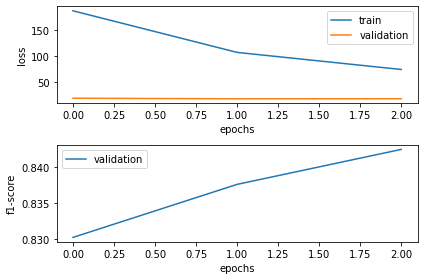

In [ ]:
plt.subplot(2, 1, 1)
plt.plot([train_loss for _, train_loss, _, _ in history], label="train")
plt.plot([eval_loss for _, _, eval_loss, _ in history], label="validation")
plt.xlabel("epochs")
plt.ylabel("loss")
plt.legend(loc="best")

plt.subplot(2, 1, 2)
plt.plot([eval_score for _, _, _, eval_score in history], label="validation")
plt.xlabel("epochs")
plt.ylabel("f1-score")
plt.legend(loc="best")

plt.tight_layout()
_ = plt.show()

## Evaluation

In [ ]:
def get_label_and_predicted_tags(batch):
  batch = {k: v.to(device) for k, v in batch.items()}
  with torch.no_grad():
    outputs = model(**batch)
  preds_cpu = torch.argmax(outputs.logits, dim=-1).cpu().numpy()
  labels_cpu = batch["labels"].cpu().numpy()
  labels_list, preds_list = align_predictions(labels_cpu, preds_cpu)  
  return labels_list, preds_list


id2label[-100] = "IGN"
test_labels, test_preds = [], []
for batch in test_dl:
  labels_list, preds_list = get_label_and_predicted_tags(batch)
  for labels, preds in zip(labels_list, preds_list):
    test_labels.extend(labels)
    test_preds.extend(preds)

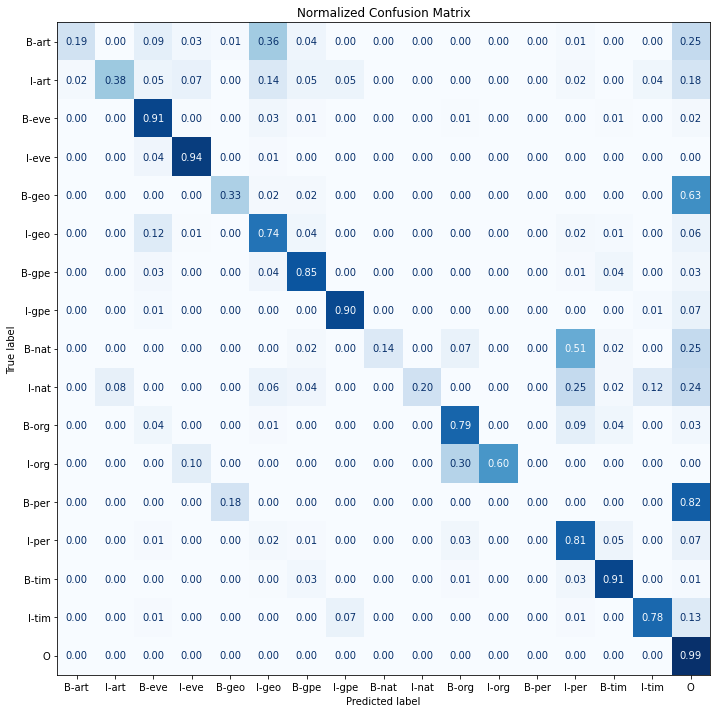

In [ ]:
def plot_confusion_matrix(ytrue, ypreds, labels):
  cm = confusion_matrix(ytrue, ypreds, normalize="true")
  fig, ax = plt.subplots(figsize=(12, 12))
  disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
  disp.plot(cmap="Blues", values_format="0.2f", ax=ax, colorbar=False)
  plt.title("Normalized Confusion Matrix")
  _ = plt.show()


plot_confusion_matrix(test_labels, test_preds, tag_names)

## Usage

In [ ]:
def align_tokens_and_predicted_labels(toks_cpu, preds_cpu):
  aligned_toks, aligned_preds = [], []
  prev_tok = None
  for tok, pred in zip(toks_cpu, preds_cpu):
    if tok.startswith("##") and prev_tok is not None:
      prev_tok += tok[2:]
    else:
      if prev_tok is not None:
        aligned_toks.append(prev_tok)
        aligned_preds.append(id2label[prev_pred])
      prev_tok = tok
      prev_pred = pred
  if prev_tok is not None:
    aligned_toks.append(prev_tok)
    aligned_preds.append(id2label[prev_pred])
  return aligned_toks, aligned_preds


def predict(texts):
  aligned_tok_list, aligned_pred_list = [], []
  for text in texts:
    inputs = tokenizer(text, return_tensors="pt").to(device)
    outputs = model(**inputs)
    tokens_cpu = tokenizer.convert_ids_to_tokens(inputs.input_ids.view(-1))
    preds_cpu = torch.argmax(outputs.logits, dim=-1)[0].cpu().numpy()

    aligned_toks, aligned_preds = align_tokens_and_predicted_labels(tokens_cpu, preds_cpu)

    aligned_tok_list.append(aligned_toks)
    aligned_pred_list.append(aligned_preds)

  return aligned_tok_list, aligned_pred_list


predicted_tokens, predicted_tags = predict([
         ["Marie Curie won the Nobel Prize in 1903 and 1911 ."],
         ["Joe Biden is the current President of the United States ."]
])

In [ ]:
pd.DataFrame([predicted_tokens[0], predicted_tags[0]], index=["tokens", "predicted_tags"])

,0,1,2,3,4,5,6,7,8,9,10,11,12
tokens,[CLS],Marie,Curie,won,the,Nobel,Prize,in,1903,and,1911,.,[SEP]
predicted_tags,O,B-per,I-per,O,O,B-org,I-org,O,B-tim,I-tim,I-tim,O,O


In [ ]:
pd.DataFrame([predicted_tokens[1], predicted_tags[1]], index=["tokens", "predicted_tags"])

,0,1,2,3,4,5,6,7,8,9,10,11,12
tokens,[CLS],Joe,Biden,is,the,current,President,of,the,United,States,.,[SEP]
predicted_tags,O,B-per,I-per,O,O,O,B-per,O,O,B-geo,I-geo,O,O


## Save Model

In [ ]:
# !cp -r data/bert-base-cased-gmb-ner/ /content/drive/MyDrive/odsc-2022-data/GMB/
!cp -r data/distilbert-base-cased-gmb-ner/ /content/drive/MyDrive/odsc-2022-data/GMB/

In [ ]:
# !ls /content/drive/MyDrive/odsc-2022-data/GMB/bert-base-cased-gmb-ner/
!ls /content/drive/MyDrive/odsc-2022-data/GMB/distilbert-base-cased-gmb-ner/

ckpt-1	ckpt-2	ckpt-3	history.tsv
